## Load data

In [2]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
# algo = "reverse_hybrid"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [4]:
patient_df.columns

Index(['patientId', 'sampleId', 'CLL_EPITYPE', 'DISEASE_TYPE', 'IGLV3_21_R110',
       'MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 'TUMOR_MOLECULAR_SUBTYPE',
       'U1_STATUS', 'AGE', 'AGE_SAMPLING', 'COHORT', 'DEATH_DAYS',
       'EXPRESSION_CLUSTER', 'FFS_MONTHS', 'FFS_STATUS',
       'IGHV_IDENTITY_PERCENTAGE', 'IGHV_MUTATION_STATUS', 'OS_MONTHS',
       'OS_STATUS', 'PRIOR_TREATMENT_CATEGORY', 'SEX',
       'TREATMENT_AFTER_SAMPLING', 'TREATMENT_STATUS', 'originId', 'year',
       'originType', 'originIdentifier'],
      dtype='object')

In [5]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

merged_df.shape

(1062, 30)

In [6]:
# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

## Clinical Analysis

AGE_SAMPLING across communities: Kruskal-Wallis H=3.16, p=0.0756
MUTATION_COUNT across communities: Kruskal-Wallis H=7.56, p=0.005961


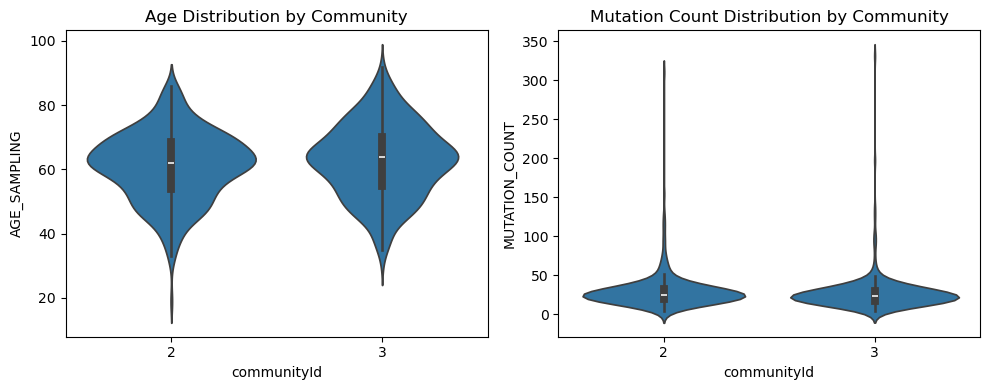

In [7]:
# Test for statistical difference in AGE_SAMPLING and MUTATION_COUNT across communities

from scipy.stats import kruskal

new_df = merged_df.copy()
# drop communityId 3
new_df = new_df[new_df['communityId'].isin([2, 3])]

# Drop missing values for each feature
age_groups = [group['AGE_SAMPLING'].dropna() for _, group in new_df.groupby('communityId')]
mutation_groups = [group['MUTATION_COUNT'].dropna() for _, group in new_df.groupby('communityId')]

# Kruskal-Wallis test (non-parametric, for comparing distributions across >2 groups)
age_stat, age_p = kruskal(*age_groups)
mut_stat, mut_p = kruskal(*mutation_groups)

print(f"AGE_SAMPLING across communities: Kruskal-Wallis H={age_stat:.2f}, p={age_p:.4g}")
print(f"MUTATION_COUNT across communities: Kruskal-Wallis H={mut_stat:.2f}, p={mut_p:.4g}")

# Optional: visualize distributions
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.violinplot(data=new_df, x='communityId', y='AGE_SAMPLING')
plt.title('Age Distribution by Community')
plt.subplot(1,2,2)
sns.violinplot(data=new_df, x='communityId', y='MUTATION_COUNT')
plt.title('Mutation Count Distribution by Community')
plt.tight_layout()
plt.show()

In [8]:
# use plotly to plot violin plots for age of all communities in one figure
import plotly.express as px
def display_community_violin_plot(df, x_col, y_col, title):
    fig = px.violin(df, x=x_col, y=y_col, 
                     title=title,
                     box=True, points='all', hover_data=['patientId'])
    fig.update_layout(xaxis_title=x_col, yaxis_title=y_col)
    fig.show()

In [9]:
display_community_violin_plot(merged_df, x_col='communityId', y_col='TMB_NONSYNONYMOUS', title='TMB Distribution by Community')

In [10]:
# For age
bins = []
for cid in merged_df['communityId'].unique():
    mutations = merged_df[merged_df['communityId'] == cid]['MUTATION_COUNT'].dropna()
    bins.append((cid, mutations.min(), mutations.max()))
print("Community mutation count bins:", bins)
# Now use these min/max to define pd.cut bins for patient_df

Community mutation count bins: [(np.int64(0), np.float64(7.0), np.float64(320.0)), (np.int64(1), np.float64(4.0), np.float64(556.0)), (np.int64(2), np.float64(4.0), np.float64(310.0)), (np.int64(3), np.float64(4.0), np.float64(331.0))]


In [17]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

def bin_and_compare(patient_df, community_df, feature, bins, bin_labels=None):
    """
    Bin patients by a feature and compare to community assignments using NMI and ARI.
    - feature: column name in patient_df (e.g. 'AGE_SAMPLING', 'MUTATION_COUNT')
    - bins: list of bin edges (e.g. [0, 60, 70, 80, 100])
    - bin_labels: optional, list of labels for bins (e.g. [0,1,2,3])
    For overlapping patients, assign to the first community (sorted).
    """
    # Assign bin label to each patient
    patient_df = patient_df.copy()
    patient_df['bin_label'] = pd.cut(patient_df[feature], bins=bins, labels=bin_labels, include_lowest=True)
    
    # Assign each patient to a single community (first if overlapping)
    comm_map = (
        community_df.groupby('patientId')['communityId']
        .apply(lambda x: sorted(x)[0])  # assign to first community
        .reset_index()
    )
    patient_df = pd.merge(patient_df, comm_map, on='patientId', how='left')
    
    # Drop patients without bin or community assignment
    valid = patient_df.dropna(subset=['bin_label', 'communityId'])
    
    # Convert labels to integers for metrics
    y_true = valid['communityId'].astype(int)
    y_pred = valid['bin_label'].astype(int) if bin_labels is not None else valid['bin_label'].cat.codes
    
    # Compute NMI and ARI
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    print(f"NMI: {nmi:.3f}, ARI: {ari:.3f}")
    return nmi, ari, valid

# Example usage:
# For age bins
# age_bins = [0, 60, 64, 70, 120]
# age_labels = [1,2,3,0]
# bin_and_compare(patient_df, community_df, feature='AGE_SAMPLING', bins=age_bins, bin_labels=age_labels)

# For mutation count bins
mut_bins = [0, 23, 25, 30, 500]
mut_labels = [3, 2, 1, 0]  # Assuming these are the labels for mutation count bins
bin_and_compare(patient_df, community_df, feature='MUTATION_COUNT', bins=mut_bins, bin_labels=mut_labels)


# age_bins = [0, 0.76, 0.83, 0.96, 20]
# age_labels = [1,2,3,0]
# bin_and_compare(patient_df, community_df, feature='TMB_NONSYNONYMOUS', bins=age_bins, bin_labels=age_labels)


NMI: 0.016, ARI: 0.023


(np.float64(0.016401674319294585),
 0.022802445639250636,
         patientId   sampleId   CLL_EPITYPE DISEASE_TYPE IGLV3_21_R110  \
 0      P-CRC-0001   CRC-0001         n-CLL          CLL            No   
 1      P-CRC-0002   CRC-0002         n-CLL          CLL            No   
 2      P-CRC-0003   CRC-0003         n-CLL          CLL            No   
 3      P-CRC-0004   CRC-0004         m-CLL          CLL            No   
 4      P-CRC-0005   CRC-0005         n-CLL          CLL            No   
 ...           ...        ...           ...          ...           ...   
 1138  P-SCLL-0502  SCLL-0502         m-CLL          CLL           NaN   
 1139  P-SCLL-0503  SCLL-0503         m-CLL          CLL           NaN   
 1140  P-SCLL-0504  SCLL-0504         n-CLL          CLL           NaN   
 1141  P-SCLL-0505  SCLL-0505         n-CLL          CLL           NaN   
 1142  P-SCLL-0506  SCLL-0506  unclassified          CLL           NaN   
 
       MUTATION_COUNT  TMB_NONSYNONYMOUS TUMOR_MOLEC

In [12]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [13]:
# --- Combine Age and Mutation Bins, Compare to Community ---

def bin_combine_and_compare(patient_df, community_df, age_bins, mut_bins, age_labels=None, mut_labels=None):
    """
    Assigns each patient to a combined age+mutation bin, then compares to community assignments.
    - age_bins: list of bin edges for age (length 3 for 2 bins)
    - mut_bins: list of bin edges for mutation count (length 3 for 2 bins)
    - age_labels, mut_labels: optional, should be [0,1] or similar
    """
    df = patient_df.copy()
    df['age_bin'] = pd.cut(df['AGE_SAMPLING'], bins=age_bins, labels=age_labels, include_lowest=True)
    df['mut_bin'] = pd.cut(df['MUTATION_COUNT'], bins=mut_bins, labels=mut_labels, include_lowest=True)
    # Combine into a single category: 0,1,2,3
    df['combined_bin'] = df['age_bin'].astype(str) + df['mut_bin'].astype(str)
    # Map to 0-3
    combo_map = {f"{a}{m}": i for i, (a, m) in enumerate([(a, m) for a in (age_labels or [0,1]) for m in (mut_labels or [0,1])])}
    df['combined_bin'] = df['combined_bin'].map(combo_map)

    # Assign each patient to a single community (first if overlapping)
    comm_map = (
        community_df.groupby('patientId')['communityId']
        .apply(lambda x: sorted(x)[0])
        .reset_index()
    )
    df = pd.merge(df, comm_map, on='patientId', how='left')
    # Drop missing
    valid = df.dropna(subset=['combined_bin', 'communityId'])

    display(valid['combined_bin'].value_counts())
    display(valid['age_bin'].value_counts())
    display(valid['mut_bin'].value_counts())
    display(valid['communityId'].value_counts())

    y_true = valid['communityId'].astype(int)
    y_pred = valid['combined_bin'].astype(int)
    # Compute NMI and ARI
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    print(f"NMI: {nmi:.3f}, ARI: {ari:.3f}")
    # return nmi, ari, valid

# Example usage:
age_bins = [0, 60, 120]
mut_bins = [0, 25, 500]
age_labels = [0, 1]
mut_labels = [0, 1]
bin_combine_and_compare(patient_df, community_df, age_bins, mut_bins, age_labels, mut_labels)

combined_bin
3.0    302
2.0    263
0.0    220
1.0    138
Name: count, dtype: int64

age_bin
1    565
0    358
Name: count, dtype: int64

mut_bin
0    483
1    440
Name: count, dtype: int64

communityId
3.0    340
2.0    266
0.0    255
1.0     62
Name: count, dtype: int64

NMI: 0.014, ARI: 0.013


In [14]:
def mutation_percent_by_community(mutation_annotated, gene_list):
    """
    For each gene in gene_list, compute the percentage of patients in each community
    who have that mutation. Each patient is assigned to their smallest community if overlapping.
    """
    # Assign each patient to their smallest community
    patient_comm = (
        mutation_annotated[['patientId', 'communityId']]
        .drop_duplicates()
        .groupby('patientId')['communityId']
        .min()
        .reset_index()
    )
    # Get all patients per community
    comm_patient_counts = patient_comm['communityId'].value_counts().sort_index()
    results = []
    for gene in gene_list:
        # Patients with this mutation
        gene_patients = (
            mutation_annotated[mutation_annotated['hugoGeneSymbol'] == gene]
            .drop_duplicates(subset=['patientId', 'communityId'])
            .groupby('patientId')['communityId']
            .min()
            .reset_index()
        )
        # Count per community
        gene_counts = gene_patients['communityId'].value_counts().sort_index()
        # Calculate percentage
        for comm in comm_patient_counts.index:
            pct = 100 * gene_counts.get(comm, 0) / comm_patient_counts[comm]
            results.append({
                'gene': gene,
                'communityId': comm,
                'pct_patients': pct,
                'n_patients': gene_counts.get(comm, 0),
                'n_total': comm_patient_counts[comm]
            })
    return pd.DataFrame(results)

# Example usage:
gene_list = ['TP53', 'NOTCH1', 'SF3B1', 'TTN',  'ATM', 'PCLO','EGR2', 'MGA', 'FAT4', 'NOTCH1', 'XPO1', 'CHD2', 'RYR2', 'FAT1','MUC16', 'LRP1B', 'USH2A', 'CSMD3', 'POT1', 'ZFHX4', 'BRAF']
# mutation_percent_by_community(mutation_annotated, gene_list).to_csv("mutations_by_community.csv", index=True)

In [15]:
# in mutations annotated, get number of unique hugoGeneSymbols only present in that community
def unique_genes_per_community(mutation_annotated, community_id):
    # Get unique hugoGeneSymbols for each community
    unique_genes = (
        mutation_annotated[mutation_annotated['communityId'] == community_id]
        ['hugoGeneSymbol']
    )
    other_genes = (
        mutation_annotated[mutation_annotated['communityId'] != community_id]
        ['hugoGeneSymbol']
    )

    # Find genes unique to this community
    unique_genes = set(unique_genes) - set(other_genes)

    print(f"Unique genes in community {community_id}: {len(unique_genes)} {unique_genes}")
    # Return the number of unique genes
    return unique_genes

# Example usage:
unique_genes_per_community(mutation_annotated, 0)
unique_genes_per_community(mutation_annotated, 1)
unique_genes_per_community(mutation_annotated, 2)
unique_genes_per_community(mutation_annotated, 3)

Unique genes in community 0: 1826 {'CMBL', 'TPSD1', 'CSNK2A1', 'HYAL2', 'MYEOV', 'LRP10', 'ACTR6', 'TMEM199', 'SIAH3', 'FUT1', 'RPL35', 'ALOXE3', 'FHIT', 'NELFCD', 'ZNF479', 'PLK1', 'H3C6', 'POLR3E', 'LINC02915', 'DBT', 'CD79A', 'CFC1', 'SCYL1', 'COPS7B', 'PUM3', 'CLCA1', 'CPEB1', 'IPO5', 'MAP3K9', 'AGER', 'INTS6L', 'PDP2', 'KHDRBS3', 'USP5', 'CMKLR2', 'RAD51C', 'TRIM71', 'TMEM184A', 'POLDIP3', 'KLHL8', 'FAM209A', 'TMEM74B', 'TAS2R42', 'ADAM9', 'PARS2', 'PLEKHG6', 'POLE2', 'NSRP1', 'ELAPOR2', 'VDAC3', 'SERINC5', 'COQ5', 'TCF12', 'NDUFS8', 'LTF', 'MYL4', 'WBP2', 'GJA10', 'B4GAT1', 'HOXD11', 'RMI2', 'C12ORF56', 'CISH', 'ZNF599', 'PEAK3', 'MTMR11', 'ROBO4', 'OR1A1', 'GLIPR1L1', 'PTPRE', 'TIGD2', 'SSR1', 'ANXA9', 'PROP1', 'HSF5', 'TMEM47', 'YWHAZ', 'PAXIP1', 'SCARB2', 'TIMM13', 'CAPG', 'PDE1B', 'SGK1', 'THOC5', 'COPS7A', 'ANO1', 'FOXRED1', 'CYP20A1', 'TMEM213', 'TENT5D', 'ADCY9', 'DMBX1', 'STXBP2', 'LRRC37A3', 'CDS2', 'IHH', 'SFXN5', 'TMEM51', 'LGALS4', 'PIK3AP1', 'PPP2R5C', 'VAX2', 'ZNF38

{'HOXD12',
 'LPGAT1',
 'THBS4',
 'CYC1',
 'FAF2',
 'SORCS2',
 'GPI',
 'MAGT1',
 'ZFYVE27',
 'OR1L6',
 'MPP3',
 'ACADVL',
 'C1RL',
 'STX19',
 'ZSCAN31',
 'ATP5PD',
 'CEBPZ',
 'DNAJB13',
 'FNTB',
 'FSD1',
 'TLE4',
 'TRPC6',
 'SPRR3',
 'FOXF2',
 'FUCA1',
 'HHEX',
 'NOP14',
 'ST6GALNAC4',
 'LRRN4CL',
 'GLI4',
 'MGST1',
 'WDHD1',
 'GIPC3',
 'TLR5',
 'PRR15L',
 'ZNF624',
 'UXS1',
 'SLC35D2',
 'HCLS1',
 'SH3KBP1',
 'LPCAT2',
 'DPCD',
 'CHIC1',
 'VASH1',
 'NDUFS1',
 'MRGPRX1',
 'CBLL1',
 'FTSJ1',
 'MYOZ2',
 'CTU1',
 'NIPSNAP1',
 'SNX8',
 'NEK4',
 'OR14J1',
 'OR2T1',
 'MAGEA1',
 'SCP2',
 'NHP2',
 'GOLM1',
 'HSD17B1',
 'RHBDD2',
 'EPS8L1',
 'TANC1',
 'ARHGEF5',
 'METAP1D',
 'G2E3',
 'PMAIP1',
 'RNF25',
 'WTAP',
 'OTUD6B',
 'CRTC3',
 'PFKFB1',
 'C1ORF56',
 'SH3TC1',
 'GJB4',
 'FBXO28',
 'SPAG16',
 'ATAD3B',
 'BLMH',
 'TAS2R14',
 'C7ORF33',
 'PRL',
 'HSD17B3',
 'DNAH12',
 'CLDN6',
 'GGH',
 'ZACN',
 'ACVR1C',
 'HAND2',
 'NFE2L2',
 'WDR46',
 'DNAJC2',
 'CHRM5',
 'DDB1',
 'DMTN',
 'FARS2',
 'CXCL8',


In [16]:
mutation_annotated['hugoGeneSymbol'].nunique()

11020